In [1]:
import argparse
import os
import random
import time
from distutils.util import strtobool

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

from huggingface_hub import HfApi, upload_folder
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import tempfile
import json
import shutil
import imageio

C:\Users\shich\AppData\Local\Temp\ipykernel_20508\1998064779.py:5: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.util import strtobool


In [2]:

class Agent(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )
        self.actor = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.Softmax(),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)

In [ ]:
class args:
    exp_name = "default name"
    seed = 0
    torch_deterministic = True
    cuda = True
    track = False
    
    num_steps = 200
    batch_size = 200
    num_envs = 1
    total_timesteps = 500000
    learning_rate = 2.5e-4
    num_envs = 4
    anneal_lr = True
    gae = False # True
    gamma = 0.99
    gae_lambda = 0.95
    num_minibatches = 4
    update_epochs = 4
    norm_adv = True
    clip_coef = 0.2
    clip_vloss = True
    ent_coef = 0.01
    vf_coef = 0.5
    max_grad_norm = 0.5
    
    minibatch_size = 200 // num_minibatches

In [11]:
# seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
# envs = gym.vector.SyncVectorEnv(
#     [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
# )
envs = gym.make('CartPole-v0')

agent = Agent().to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)
num_updates = args.total_timesteps // args.batch_size

cum_rewards = []

from tqdm import tqdm

pbar = tqdm(range(1, num_updates + 1))
for update in pbar:
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    

    next_obs = torch.Tensor(envs.reset()).to(device)
    next_done = torch.zeros(args.num_envs).to(device)
    obs.zero_()
    actions.zero_()
    logprobs.zero_()
    rewards.zero_()
    dones.zero_()
    values.zero_()

    for step in range(0, args.num_steps):
        global_step += 1 * args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs.float())
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.tensor(next_obs).to(device), torch.tensor(done).to(device)

    cum_rewards.append(rewards.sum().item())
    pbar.set_postfix({"rewards": cum_rewards[-1]})
    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs.float()).reshape(1, -1)
        if args.gae:
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done.float()
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
            returns = advantages + values
        else:
            returns = torch.zeros_like(rewards).to(device)
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done.float()
                    next_return = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_return = returns[t + 1]
                returns[t] = rewards[t] + args.gamma * nextnonterminal * next_return
            advantages = returns - values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = mb_advantages * ratio
            pg_loss2 = mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = -torch.min(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

100%|██████████| 2500/2500 [14:26<00:00,  2.88it/s, rewards=280]


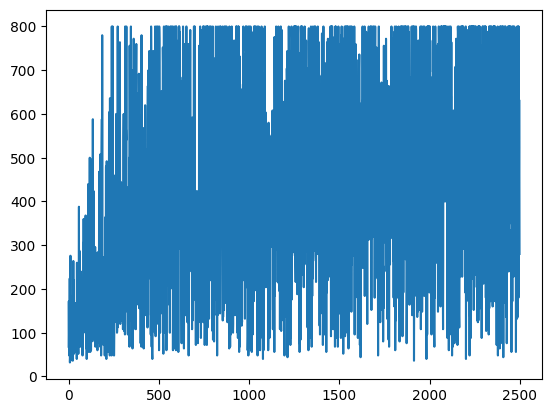

In [12]:
import matplotlib.pyplot as plt

plt.plot(cum_rewards)